# Anomaly Detection

## Types of Anomalies

### Point Anomalies
A point anomaly is a single data point that is significantly different from the rest of the data. These anomalies are often caused by errors in data collection or measurement. Point anomalies can be easily identified by visual inspection of the data plot or by using statistical methods such as the z-score or interquartile range.

### Contextual Anomalies
Contextual anomalies are anomalies that are only considered anomalous in a specific context. For example, a sudden increase in temperature might be considered normal for a summer day, but anomalous for a winter day. Contextual anomalies can be more difficult to detect than point anomalies, as they require a deeper understanding of the data and its context. Also known as conditional anomalies.

### Collective Anomalies
Collective anomalies are anomalies that occur as a group, but not as individual data points. These anomalies are often caused by a combination of individual anomalies that are not anomalous on their own. Collective anomalies can be difficult to detect, as they require the identification and analysis of patterns within the data. Clustering algorithms and other machine learning techniques are often used to detect collective anomalies.

## Sliding Window
Sliding windows are a common technique used in anomaly detection to analyze time series data. A sliding window is a fixed-size window that moves over the time series data one step at a time. At each step, the data within the window is analyzed to detect any anomalies. Sliding windows can be used with various statistical methods, such as moving average, to detect anomalies in the time series data.

It is usually applied to time-series data (measurements at a fixed temporal rate, harder to apply when timings are not fixed). But it only takes a fixed-length history into account and causes a modelling blow-up

Cross-validation fails for time series.

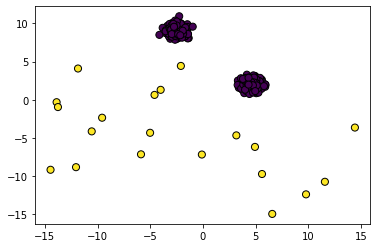

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
import random

X, _ = make_blobs(
   n_samples=500, n_features=2,
   centers=2, cluster_std=0.5,
   shuffle=True, random_state=42
)

X_anomaly, _ = make_blobs(
   n_samples=20, n_features=2,
   centers=8, cluster_std=4,
   shuffle=True, random_state=84
)

X = np.concatenate([X,X_anomaly])

y = np.concatenate([np.array([0]*500), np.array([1]*20)])
def plot_graph(X, y):
  plt.scatter(
      X[:, 0], X[:, 1],
      c = y, marker='o',
      edgecolor='black', s=50
      )
  plt.show()
plot_graph(X,y)
def euclidean_distance(a: np.array, b: np.array) -> float:
  return np.sqrt(np.sum(np.power(a - b, 2)))

## Isolation Forest
- Repeat N times:
    * Randomly pick a feature f
    * Split the f uniformly at randomly between [min,max]
    * Continue until all leaves contain singletons
- The path length to reach a leaf is the isolation score
- Average this length over all trees to get the anomaly score
- Intuition:
    * isolating anomalies is easier because only a few conditions are needed to separate those cases from the normal observations

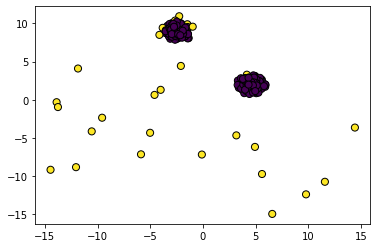

In [2]:
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.data = None
        self.feature = None
def isolation_forest(X: np.array, N: int, anomalies: float) -> np.array:
  def generate_tree(X: np.array) -> Tree:
    if len(X) <= 1:
      return Tree()
    f = random.randint(0,X.shape[1]-1)
    split = random.uniform(np.min(X[:,f]), np.max(X[:,f]))
    left = np.array([i for i in X if i[f] < split])
    right = np.array([i for i in X if i[f] > split])
    res = Tree()
    res.feature = f
    res.data = split
    res.left = generate_tree(left)
    res.right = generate_tree(right)
    return res
  def query_tree(value: np.array, tree: Tree) -> int:
    if tree.feature == None:
      return 0
    if value[tree.feature] > tree.data:
      return 1 + query_tree(value, tree.right)
    return 1 + query_tree(value, tree.left)
  trees = []
  for i in range(N):
    trees.append(generate_tree(X))

  isolation_scores = [np.mean([query_tree(i,j) for j in trees]) for i in X]
  threshold = sorted(isolation_scores)[int(len(X)*anomalies)]
  return [0 if i > threshold else 1 for i in isolation_scores]
plot_graph(X, isolation_forest(X,100,0.05))

## Distance Based vs Density Based
Distance-based
    A point is anomalous when it is far from other points
Density-based
    A point is anomalous when it is in a low density region

## Density-based outlier detection LOF
- The local outlier factor is based on a concept of a local density
    * locality is given by k nearest neighbors
    * distance to k neighbors is used to estimate the density
- Points that have a substantially lower density than their neighbors are considered to be anomalies
- The local density is estimated by the typical distance at which a point can be "reached" from its neighbors.
    * The definition of "reachability distance" used in LOF is an additional measure to produce more stable results within clusters
- For each data point q compute the distance to the k-th nearest neighbor (k-distance(q) )
- Compute reachability distance (reach-dist) for each data example q from data example p as: reach-dist(q, p) = max{ k-distance(p), d(q,p) }
- Compute local reachability density (lrd) of data example q as inverse of the average reachability distance based on the MinPts (k) nearest neighbors of data example q
- Compute LOF(q) as ratio of average local reachability density of q’s k-nearest neighbors and local reachability density of the data record q

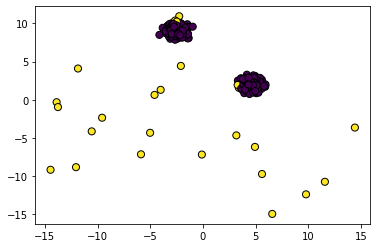

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def local_outlier_factor(X, n_neighbors=5, contamination=0.1):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)
    local_reachability_density = np.zeros(X.shape[0])
    for i in range(len(indices)):
        k_distance = distances[i][-1]
        local_reachability_density[i] = n_neighbors / k_distance

    lrd_ratio = local_reachability_density / np.mean(local_reachability_density)
    lof_score = np.mean(lrd_ratio[indices], axis=1)
    threshold = np.percentile(lof_score, 100 * contamination)
    outliers = lof_score < threshold

    return outliers
lof_res = local_outlier_factor(X,5,0.05)
plot_graph(X, lof_res)

## N-grams

N-grams are a technique used in natural language processing for anomaly detection. They involve breaking down text into sequences of contiguous words, called n-grams, and analyzing the frequency of occurrence of these n-grams. Unusual n-grams, or n-grams that occur with a much higher or lower frequency than expected, can indicate the presence of anomalies in the text data. N-gram analysis can be used for tasks such as spam detection or identifying unusual language patterns in customer service interactions.

Almost always needed  to be combined with smoothing methods to avoid overfitting.

## Smoothing
Smoothing is a technique used to reduce the noise in time series data and make it easier to detect anomalies. This involves applying a mathematical function to the time series data, such as a moving average or exponential smoothing, to create a new time series that is smoother and easier to analyze. Smoothing can help to identify long-term trends and patterns in the data, which can be useful for detecting anomalies that occur over longer periods of time.